In [14]:
import os
import numpy as np
import glob
import PIL.Image as Image
import random
import tifffile as tiff
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# --- PROJECT SETUP ---
PROJECT_ROOT = Path.cwd().parent.parent
sys.path.append(str(PROJECT_ROOT))
print(PROJECT_ROOT)

from func.dataloaders import ImageMaskDataset, unlabeledData
from func.Models import SemiSupervisedUNet


c:\Users\gusta\UniGit\02456-final-project


In [15]:
def dice_coefficient(pred, target, eps=1e-7):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))

    dice = (2 * intersection + eps) / (union + eps)
    return dice.mean()

def iou_score(pred, target, eps=1e-7):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - intersection

    iou = (intersection + eps) / (union + eps)
    return iou.mean()

In [16]:

DATA_DIR = PROJECT_ROOT / 'archive'
datasetSupervised = ImageMaskDataset(
    DATA_DIR / "Original_images",
    DATA_DIR / "Original_masks",
    resize=(512, 512)
)

datasetUnlabled = unlabeledData(
    DATA_DIR / "unlabeled",
    resize=(512, 512)
)

train_size = int(0.8 * len(datasetSupervised))
val_size = int(0.1 * len(datasetSupervised))
test_size = len(datasetSupervised) - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(
    datasetSupervised, [train_size, val_size, test_size]
)

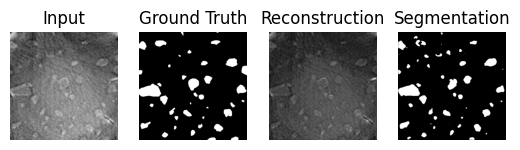

In [18]:
device = torch.device('cpu')

# Load model
model = SemiSupervisedUNet(1)
state_dict = torch.load("../../Trained_models/MultiTask_Unet_Best/best_model.pth", map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# Get a test sample
test_img, mask = test_dataset[0]  # index your sample
test_img = test_img.unsqueeze(0).to(device)  # add batch dimension
mask = mask.to(device)

# Forward pass
with torch.no_grad():
    recon, seg = model(test_img)

# Remove batch dimension if needed
recon = recon.squeeze(0)
seg = seg.squeeze(0).cpu()
#seg_prob = torch.sigmoid(seg.squeeze(0).cpu())  # probabilities
seg_binary = (seg > 0.5).float() 

plt.subplot(1,4,1)
plt.title("Input")
plt.axis('off')
plt.imshow(test_img.squeeze().cpu(), cmap='gray')


plt.subplot(1,4,3)
plt.title("Reconstruction")
plt.axis('off')
plt.imshow(recon.squeeze().cpu(), cmap='gray')

plt.subplot(1,4,4)
plt.title("Segmentation")
plt.axis('off')
plt.imshow(seg_binary.squeeze().cpu(), cmap='gray')


plt.subplot(1,4,2)
plt.title("Ground Truth")
plt.axis('off')
plt.imshow(mask.squeeze().cpu(), cmap='gray')
plt.show()

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device('cpu')

# Load model
model = SemiSupervisedUNet(1)
state_dict = torch.load("../../Trained_models/MultiTask_Unet_Best/best_model.pth", map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# Loss function
bce_loss_fn = nn.BCEWithLogitsLoss()

# DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

total_bce = 0.0
total_dice = 0.0
total_iou = 0.0
num_samples = 0

with torch.no_grad():
    for test_img, mask in test_loader:
        test_img = test_img.to(device)
        mask = mask.to(device)

        _, seg = model(test_img)  # ignore reconstruction output

        # Compute metrics
        bce = bce_loss_fn(seg, mask)
        dice = dice_coefficient(seg, mask)
        iou = iou_score(seg, mask)

        total_bce += bce.item() * test_img.size(0)
        total_dice += dice.item() * test_img.size(0)
        total_iou += iou.item() * test_img.size(0)
        num_samples += test_img.size(0)

# Average metrics over test set
avg_bce = total_bce / num_samples
avg_dice = total_dice / num_samples
avg_iou = total_iou / num_samples

print(f"Test BCE Loss: {avg_bce:.4f}")
print(f"Test Dice Coefficient: {avg_dice:.4f}")
print(f"Test IoU Score: {avg_iou:.4f}")



Test BCE Loss: 0.1610
Test Dice Coefficient: 0.7848
Test IoU Score: 0.6485


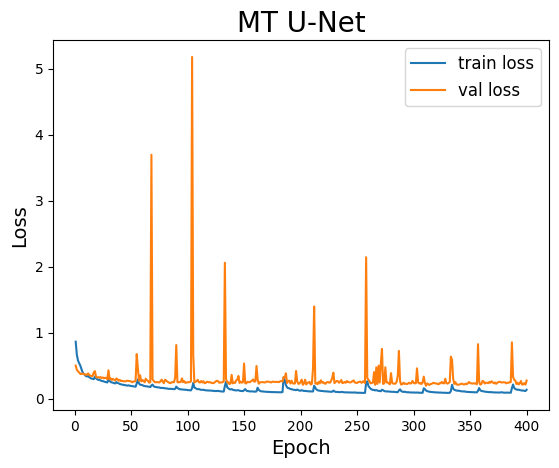

In [20]:
metric = torch.load("../../logs/MultiTask_UNet_train.pth", map_location=device)

num_epochs = len(metric["train_loss"])
epochs = np.arange(1, num_epochs + 1)

plt.plot(epochs, metric["train_loss"], label = "train loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")


plt.plot(epochs, metric["val_loss"], label = "val loss")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title('MT U-Net', fontsize=20)
plt.legend(fontsize=12)
plt.show()

In [21]:
print(max(metric["val_dice"]), max(metric["val_loss"]))

0.6957474946975708 5.177388668060303
